# Machine Learning in Python Project 2 

Due Friday, April 16th by 5 pm UK local time.

Stephen Gallagher, Ishaan S Jolly, Mariel Reyes-Salazar, Julia Stachurska

## 0. Setup

In [2]:
# Install required packages
!pip install -q -r requirements.txt

In [3]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
import sklearn.tree
import sklearn.cluster
import sklearn.ensemble 
import sklearn.neighbors
from sklearn import tree
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

import itertools
from time import time
import joblib
import warnings
warnings.filterwarnings('ignore')

#helper function 
from helper import *

In [4]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction
In this project, we help hotel operators understand patterns in their customers' bookings and the reasons why customers cancel their reservations. We referenced the dataset by Antonio, Almeida and Nunes. This data set contains information collected from two hotels located in Portugal: a resort hotel and a city hotel situated in Lisbon. We noticed that similar features were reported, such as the total number of special requests, the number of adults, children and babies. In addition to these features, because the dataset provided to us differs from Antonio, our feature section included additional features for efficacy and to ensure better predictions are rendered. 

Before exploring the data, we first divided the data into three sets: test, train and validation. We also realised that the dataset lacked several values for children, country, agent and company. Our team assumed that those missing values are a result of human error and thus chose to impute the values for these variables based on median and mode. Following data were explored through a series of figures and the importance of each variable was noted to affirm our feature selection. 

After feature engineering, our team trained the model, multiple models, on our training set and tested it on the validation set and then on the testing set, respectively. Moreover, the Logistic Regression model is our baseline model. 



In [5]:
# Descriptive statistics
d.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


Firstly, let us find any "NA" values in the data and what propotion of the data it takes. 

In [6]:
# Find NA in the data
d_na = find_na(d)
d_na


,column_name,na_values,not_na,proportion_na,propotion_not_na
0,children,4,119386,0.000034,0.999966
1,country,488,118902,0.004087,0.995913
2,agent,16340,103050,0.136862,0.863138
3,company,112593,6797,0.943069,0.056931


There are 4 variables that contain "NaN" values. In particular, we can see that the company column contains 112,593 "NaN" values, comprising 94.31% of the variables observations, hence it does not provide us with any information.  
Let us investigate the balance of the classes. 

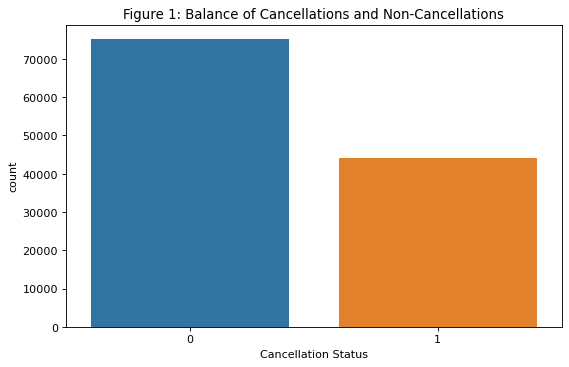

In [7]:
# Looking at the balance of the two classes:

sns.countplot(d["is_canceled"])
plt.title('Figure 1: Balance of Cancellations and Non-Cancellations')
plt.xlabel('Cancellation Status')
plt.show()

We can see that the count of the two classes, canceled and not-canceled bookings, differ significantly. We will resample the dataset to balance the classes for two following reasons: to get a sufficient look at the underlying class (here `not-canceled`), and to avoid problems in making a test validation or test sample due to underrepresentation of a class. Now, we will replace all the "NaN" values with zeros. 

In the next section, we will fix this issue. 

In [8]:
# Imputing values function
d_clean = impute_values(d)

### Resampling the dataset to balance the classes
We can see that that the classes right now are not balanced, such that the number of bookings is over 70,000 and the number of cancellations is over 40,000. In order to have balanced results, we chose to balance the classes first. Having imbalanced classes can lead to incorrect predictions. 
We decided to solve this issue by performing undersampling.

In [9]:
# Creating variables for cancelled and non-cancelled samples
noncanceled_class = d_clean[d_clean["is_canceled"] == 0]
canceled_class = d_clean[d_clean["is_canceled"]==1]

# Number of cancellations
samples = canceled_class.shape[0]

# Undersample the leading class (non_canceled)
noncanceled_class_undersampled = resample(
    noncanceled_class, 
    replace= False,
    n_samples=samples, 
    random_state=123)

# Obtaining new dataset with balanced cancellation classes
d_balanced = pd.concat([noncanceled_class_undersampled, canceled_class])

Now, we can see from the plot below that our data is balanced and we can start preparing the data for the exploratory data analysis.

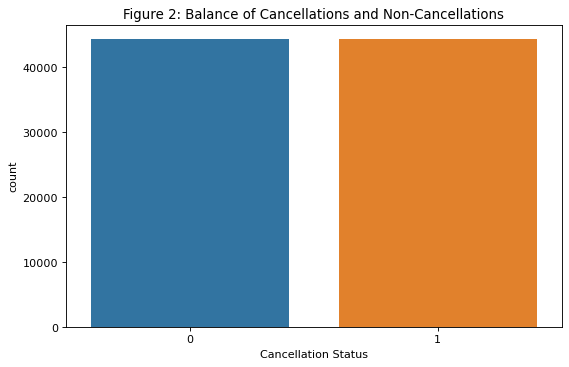

In [10]:
# Plotting the balance in the dataset
sns.countplot(d_balanced["is_canceled"])
plt.title('Figure 2: Balance of Cancellations and Non-Cancellations')
plt.xlabel('Cancellation Status')
plt.show()

### Converting country names
The country names are in abbreviated format which is hard to discern. We convert the country abbreviations to actual country names for better visual aid.

In [11]:
# Adding country names to replace abbreviations
d_balanced = add_country_names(d_balanced)

### Binary variables

We proceeded to convert the categorical factor variables into numerical binary variables.

In [12]:
# Creating a list of categorical variables
var = ["babies", "children", "total_of_special_requests", "booking_changes", 
"required_car_parking_spaces", "previous_cancellations", "agent"]

# Changing categorical variables into numerical binary variables
d_balanced = create_binaries(d_balanced, var)

In [13]:
# Renaming relevant classes
d_balanced = d_balanced.rename(
    columns={
        "binary_required_car_parking_spaces": "binary_car_park",
        "binary_babies": "binary_babes"
        }
        )

In [14]:
# Creating a variable for total nights stayed
d_balanced['stays_nights_total'] = d_balanced['stays_in_week_nights'] + d_balanced['stays_in_weekend_nights']

# Creating a variable for previous cancellation rate
d_balanced['previous_cancellation_rate'] = d_balanced['previous_cancellations'] / (d_balanced['previous_cancellations'] + d_balanced['previous_bookings_not_canceled'])

### Splitting data

In here, we split the data in 3 sets: train, validation and test set. A "Holdout" temporary
set is created to hold out 40% of the initial data, which will then be splitted
into a validation and test set. The holdout set is not to be used for any other purpose. 

In [15]:
# Creating a 60 - 40 split between training and holdout set
train_set, holdout = train_test_split(d_balanced, test_size=0.4, random_state=123)

# Creatining 50 - 50 split between validation and test set
val_set, test_set = train_test_split(holdout, test_size=0.5, random_state=123)

We verify that the training, validation and test set are split accordingly.

In [16]:
print(len(train_set), 'train samples')
print(len(val_set), 'validation samples')
print(len(test_set), 'test samples')
print(f'Percentage of train samples: {round(len(train_set) / len(d_balanced)*100)}%')
print(f'Percentage of validation samples: {round(len(val_set) / len(d_balanced)*100)}%')
print(f'Percentage of test samples: {round(len(test_set) / len(d_balanced)*100)}%')

53068 train samples
17690 validation samples
17690 test samples
Percentage of train samples: 60%
Percentage of validation samples: 20%
Percentage of test samples: 20%


## 2. Exploratory Data Analysis and Feature Engineering
In this section we will perform exploratory data analysis and feature engineering. We start from observing the dimensions of the dataset. 

In [17]:
header = "Dataset information"
print(header)
print("="*len(header))

# Printing data set dimensions
print("Number of rows: ", train_set.shape[0])
print("Number of columns: ", train_set.shape[1])
print("Column names:", )
for i in train_set.columns:
    print(i, end = ",")

Dataset information
Number of rows:  53068
Number of columns:  40
Column names:
country,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,country_name,binary_babes,binary_children,binary_total_of_special_requests,binary_booking_changes,binary_car_park,binary_previous_cancellations,binary_agent,stays_nights_total,previous_cancellation_rate,

### Feature selection
In this section, we investigate the features of the data set, and make the decisions on which features to include. This is a short summary of all the features we decided not to include based on our findings in the Exploratory Data Analysis.
We decided not to include `company` as a feature because 5.69% of the data consists of non-N/A values. The following features were also excluded: `arrival_date_day_of_month`,`arrival_date_month`,`arrival_date_year`, `children` and `binary_children`, `babies`, `meal`, `deposit_type_Refundable`, `is_repeated_guest`, `market_segment_Complementary`, `market_segment_Corporate`, `market_segment_Undefined`, `required_car_parking_spaces`, `reserved_room_type`, `assigned_room_type`, `distribution_channel`, `required_car_parking_spaces`, `stays_in_weekend_nights`, `stays_in_week_nights`, `stays_nights_total`, `booking_changes`, `previous_bookings_not_canceled`, `days_in_waiting_list `. 

Let us start with finding what features have variance less than 0.05 to get a better idea which features might be less relevant in our model. If a feature exhibits a variance lower than the chosen threshold, it will be removed.

In [18]:
# Get all string columns 
non_numerical_vars = [i for i in train_set.columns if train_set[i].dtype == "object"]

# Drop string columns, the outcome variable and "company" (too many NA)
all_feats = train_set.drop(columns = non_numerical_vars) 
all_feats = all_feats.drop(columns = ["is_canceled", "company"])

In [19]:
# Set threshold to 0.05. 
feat_select = VarianceThreshold(threshold = 0.05)
find_near_zero_vars = feat_select.fit_transform(all_feats)

The new "all_feats" is a dataframe after near-zero variance feature removal. It only contains the numerical variables and not string variables. Thus, although only 21 features remained, there are still 12 categorical variables.

In [20]:
# Listing variables with variance above 0.05 threshold
nonzerovariance_feats = all_feats[all_feats.columns[feat_select.get_support(indices=True)]]
nonzerovariance_feats.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,previous_cancellations,previous_bookings_not_canceled,...,agent,days_in_waiting_list,adr,total_of_special_requests,binary_children,binary_total_of_special_requests,binary_booking_changes,binary_previous_cancellations,stays_nights_total,previous_cancellation_rate
46456,74,2016,18,28,0,2,2,0.0,0,0,...,7.0,0,77.62,0,0,0,0,0,2,NaN
76275,130,2017,16,21,0,2,2,0.0,0,0,...,286.0,0,95.00,0,0,0,0,0,2,NaN
430,11,2016,47,14,1,2,2,0.0,0,0,...,7.0,0,65.10,1,0,1,0,0,3,NaN
55720,418,2016,40,26,1,2,2,0.0,0,0,...,132.0,223,107.00,0,0,0,0,0,3,NaN
24537,158,2017,15,13,1,3,2,0.0,0,0,...,7.0,0,95.29,3,0,1,0,0,4,NaN


Below we see what numerical features with variance below the chosen threshold were removed. 

In [21]:
# Find the removed variables after VarianceThreshold()
removed_vars = set([i for i in all_feats.columns]) ^ set([i for i in nonzerovariance_feats.columns])
removed_vars

{'babies',
 'binary_agent',
 'binary_babes',
 'binary_car_park',
 'is_repeated_guest',
 'required_car_parking_spaces'}

The list above shows the features that have less than 0.05 variance. This gives us a ground to investigate those features to find further evidence for their removal. 

We proceed to analyse the variables under consideration for removal.

In [22]:
# Company wide cancelation rate:
cx_rate = train_set['is_canceled'].sum()/d.shape[0] 

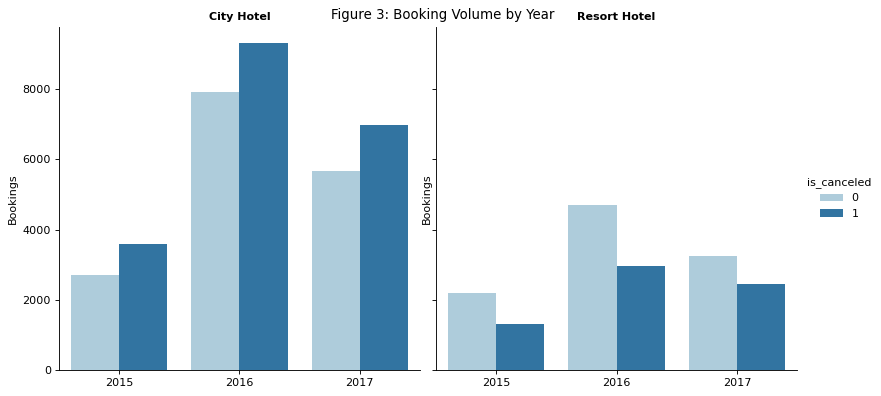

In [23]:
# Plotting the number of bookings by year and cancellation status
can_ax = sns.catplot(
        x ='arrival_date_year', # Setting x-axis
        col = 'hotel', # Splitting plot by hotel
        hue = 'is_canceled', # Adding cancellation status label
        kind = 'count', # Count plot
        palette = sns.color_palette("Paired",2),
        data = train_set.sort_values('hotel', ascending= True)
        )
can_ax.set_titles(
        col_template = "{col_name}", 
        fontweight ='bold'
        )
can_ax.set(
        ylabel = 'Bookings', 
        xlabel = '')
can_ax.fig.suptitle(
        'Figure 3: Booking Volume by Year'
        )
plt.show()

We can see that the City Hotel is more popular, but the number of cancellations are greater than the number of occured bookings. 
The Resort Hotel has less cancellations than the bookings that occured. 
In both cases, we see the increase in booking volume, however the ratio of the cancellations to the bookings occured throughout the years seem the same. We note that the ratio of cancelation to bookings for City hotel is the same for Resort Hotel as well. Thus, we can exclude `arrival_date_year` as a feature because it would not provide much variability to our results. 


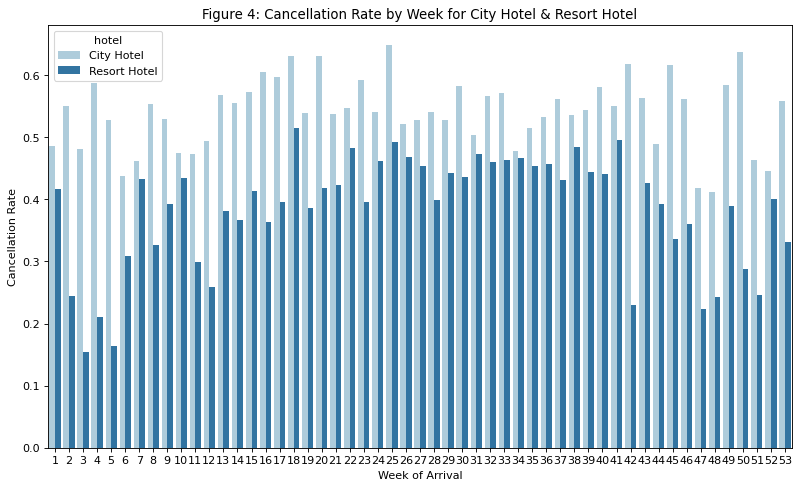

In [24]:
plt.figure(figsize = (12,7))
cancelation_rate_week = train_set[['is_canceled', 'hotel','arrival_date_week_number']].groupby(
   ['hotel', 'arrival_date_week_number', 'is_canceled']).size().reset_index(name ='count')

cancelation_rate_week = cancelation_rate_week.pivot_table(
        index = ['hotel', 'arrival_date_week_number'], 
        columns ='is_canceled', 
       values = 'count').reset_index().rename(columns = {0:'not_canceled' ,1: 'canceled'})
cancelation_rate_week['cancelation_rate'] = cancelation_rate_week.canceled/ (cancelation_rate_week.canceled + cancelation_rate_week.not_canceled)

can_rate_ax = sns.barplot(
    x = 'arrival_date_week_number', 
    hue ='hotel',
    y ='cancelation_rate',
    palette = sns.color_palette("Paired",2),
    data = cancelation_rate_week
)

plt.title('Figure 4: Cancellation Rate by Week for City Hotel & Resort Hotel')
plt.xlabel('Week of Arrival')
plt.ylabel('Cancellation Rate')
plt.show()

We observe a high level of variance in the cancellation rate by week, especially for the Resort Hotel. The cancellation rate is less variable over the weeks for the City Hotel, however we will keep this variable as a feature in the model building process as it may provide statistical prowess in determining cancellation status. Furthermore, we decide to omit the following variables due to redundancy: `arrival_date_year`, `arrival_date_month` and `arrival_date_day_of_month`. 

In [25]:
# Inspired by the methodology referenced in link 4 in the References and Hints section of the report

# Reordering of the month
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

# Cancellation rate by hotel and month
cancelation_rate = train_set[['is_canceled', 'hotel','arrival_date_month']].groupby(
    ['hotel', 'arrival_date_month', 'is_canceled']).size().reset_index(name ='count')

# Making a pivot table 
cancelation_rate = cancelation_rate.pivot_table(
        index = ['hotel', 'arrival_date_month'], 
        columns ='is_canceled', 
        values = 'count').reset_index().rename(columns = {0:'not_canceled' ,1: 'canceled'})

# Defining and adding a cancellation rate column:
cancelation_rate['cancelation_rate'] = cancelation_rate.canceled/ (cancelation_rate.canceled + cancelation_rate.not_canceled)
cancelation_rate['arrival_date_month'] = pd.Categorical(cancelation_rate['arrival_date_month'], categories = months, ordered =True)

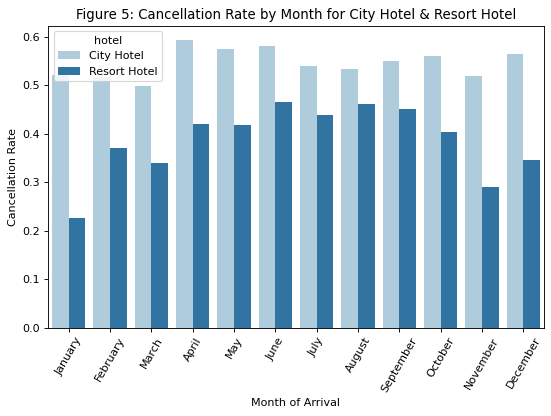

In [26]:
can_rate_ax = sns.barplot(
    x = 'arrival_date_month', 
    hue ='hotel',
    y ='cancelation_rate',
    palette = sns.color_palette("Paired",2),
    data = cancelation_rate
)

plt.xticks(rotation = 60)
plt.title('Figure 5: Cancellation Rate by Month for City Hotel & Resort Hotel')
plt.xlabel('Month of Arrival')
plt.ylabel('Cancellation Rate')
plt.show()

We can see that the cancellation rate per month for City hotel appears to be approximately uniform throughout the year. We also observe a variation in the cancellation rate for the Resort Hotel, with a significant drop in cancellation rate for the month of January and a series of peaks around the summer months. The difference in cancellation rates for both hotels between different months of the year does not appear to be a significant predictor of the cancellation rate. Thus, we will not include this feature in the model.

Now, let us see the cancellations from the perspective of the country of origin of the clients. 


In [27]:
# A dataframe of the countries and number of bookings
country_df = train_set[['is_canceled', 'country_name']].groupby( 
    ['is_canceled', 'country_name']).size().reset_index(name ='count')

# Counting how many were canceled and not canceled
country_df = country_df.pivot_table(
    index = ['country_name'], columns = 'is_canceled', values = 'count').reset_index().rename(
        columns = {0:'not_canceled', 1:'canceled'})

# Finding the cancelation rate per country
country_df['cancelation_rate'] = country_df.canceled/(country_df.canceled + country_df.not_canceled)

# Total number of people who made the did not cancel and who did cancel
country_df['flux'] = country_df['not_canceled'] + country_df['canceled']

# Share represents the total volume of people who made the cancelations and who did not with respect the data 
country_df['share'] = country_df['flux']/d.shape[0]
country_df

# Top 10 countries by flux canceled and non_canceled bookings: 
country_top  = country_df.sort_values('flux', ascending = False).head(10).country_name.unique()

# Dataframe containing Top 10 countries Volume
country_top_df = country_df[country_df['country_name'].isin(country_top)].copy().drop(
    ['flux','cancelation_rate','share'],axis=1).melt(
        id_vars = ['country_name']).rename(
            columns={'value': 'count'})

# Converts country name to a cateogrical variable 
country_top_df['country_name'] = pd.Categorical(country_top_df['country_name'], categories=country_top, ordered=True)

# Sorting 
country_top_cancelation_rate = country_df.sort_values('cancelation_rate', ascending=False).head(10).country_name.unique()

In [28]:
country_top_cancelation_rate_df = country_df[ country_df['country_name'].isin(country_top)].copy()
country_top_cancelation_rate_df['country_name'] = pd.Categorical(
    country_top_cancelation_rate_df['country_name'], categories=country_top, ordered= True
)

country_top_cancelation_rate_df.sort_values(by = 'cancelation_rate', ascending = False)


is_canceled,country_name,not_canceled,canceled,cancelation_rate,flux,share
107,Portugal,7606.0,16584.0,0.685573,24190.0,0.202613
18,Brazil,473.0,473.0,0.500000,946.0,0.007924
66,Italy,861.0,824.0,0.489021,1685.0,0.014113
123,Spain,2282.0,1331.0,0.368392,3613.0,0.030262
63,Ireland,929.0,536.0,0.365870,1465.0,0.012271
138,United States,557.0,294.0,0.345476,851.0,0.007128
137,United Kingdom,3358.0,1488.0,0.307057,4846.0,0.040590
14,Belgium,655.0,289.0,0.306144,944.0,0.007907
44,France,2981.0,1162.0,0.280473,4143.0,0.034701
48,Germany,2126.0,722.0,0.253511,2848.0,0.023855


Looking at the top ten countries in order of cancellation rate, we observe a high variance between different countries and their respective cancellation rates. From the figure above we can see that 68.56% of clients from Portugal cancel, in comparison to Brazil, which has the second highest cancellation rate of 50% (a significant drop). Moreover, the top countries in this figure account for more than 80 percent of the data set. Therefore, countries are definitely an important feature. 

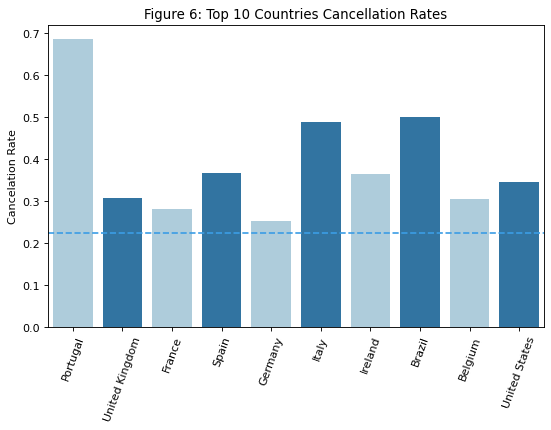

In [29]:
country_cancel_ax = sns.barplot(
    data = country_top_cancelation_rate_df, 
    y = 'cancelation_rate',
    x = 'country_name', 
    palette = sns.color_palette("Paired",2)
)

plt.xticks(rotation = 70)
country_cancel_ax.set_title('Figure 6: Top 10 Countries Cancellation Rates')

country_cancel_ax.set(
    ylabel = 'Cancelation Rate',
    xlabel = ''
)
country_cancel_ax.axhline(cx_rate, ls='--',color='#3b9de5',label='Average Cancellation Rate')
plt.show()


Figure 6 visualises the results mentioned. Again, we can see Portugal has the highest cancelation rates, then Brazil and Italy. Spain, Ireland and Belgium, United States and the UK have very similar cancelation rates, not exceeding 37%. Belgium, Germany and France are a group of countries with the least cancelation rates in the top 10 country cancellations. We decide to include this feature in our model.

Now, let us investigate the cancellations considering the deposit type. 

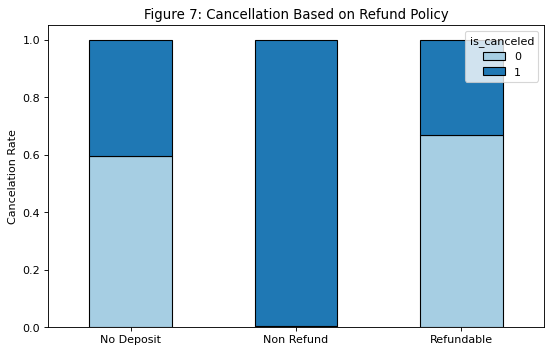

In [30]:
deposit = train_set.groupby('deposit_type')['is_canceled'].value_counts(
    normalize = True).unstack('is_canceled').plot.bar(
    stacked=True, edgecolor = 'black', color = sns.color_palette("Paired",2))

deposit.set_title(
    'Figure 7: Cancellation Based on Refund Policy'
    )
deposit.set(
    xlabel='', 
    ylabel='Cancelation Rate')

plt.xticks(rotation = 360)
plt.show()

The above result is surprising. Intuitively, having no deposit or a refundable deposit would likely encourage a cancellation, however we observe that non-refundable trips are always canceled. Thus, we include this variable as a feature in the model procedure. 

Now, let us consider other interesting features.

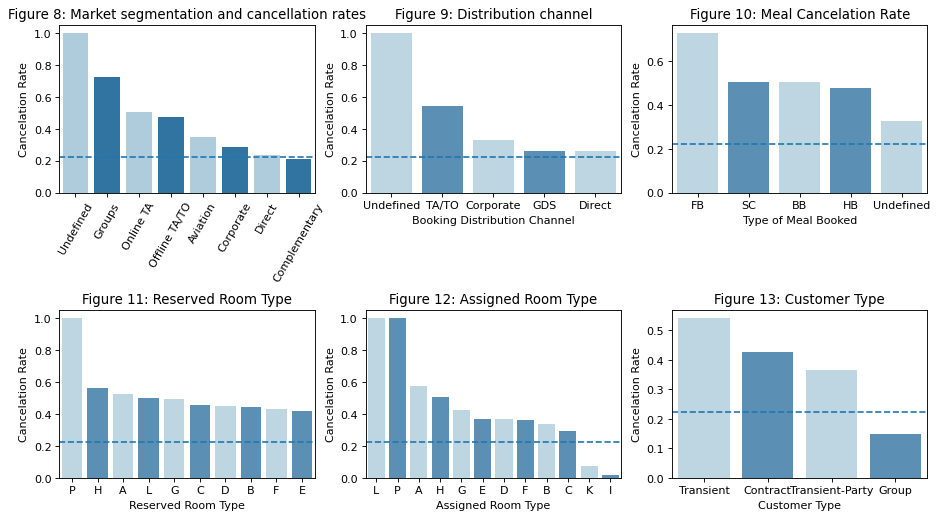

In [31]:
plt.figure(figsize = (14,7.5))

# Market Segmentation
Market = count_how_many(train_set,'market_segment')
# Market = automating_tables(train_set,'market_segment')
Market = Market.pivot_table(
        index = ['market_segment'], 
        columns = 'is_canceled', 
        values = 'count').reset_index().fillna(0).rename(columns = {0:'not_canceled', 1: 'canceled' })
Market['cancelation_rate'] = Market.canceled/(Market.canceled + Market.not_canceled)

plt.subplot(2,3,1)
Market_ax = sns.barplot( 
    x = 'market_segment', 
    y = 'cancelation_rate', 
    palette = sns.color_palette("Paired",2),
    data = Market.sort_values('cancelation_rate', ascending=False),
)
Market_ax.set_title('Figure 8: Market segmentation and cancellation rates' )
Market_ax.set(
    xlabel = '', 
    ylabel = 'Cancelation Rate')

Market_ax.axhline(cx_rate, ls='--',label='Average Cancellation Rate')
plt.xticks(rotation = 60)

# Distribution channel 
distribution_rate = count_how_many(train_set,'distribution_channel')
distribution_rate = distribution_rate.pivot_table(
    index = ['distribution_channel'], 
    columns ='is_canceled', 
    values = 'count').reset_index().fillna(0).rename(
        columns ={0:'not_canceled', 1:'canceled'}
    )
distribution_rate
distribution_rate['cancelation_rate'] = distribution_rate.canceled/ (distribution_rate.canceled + distribution_rate.not_canceled)
plt.subplot(2,3,2)
distribution_rate_ax = sns.barplot(
    x ='distribution_channel', 
    y = 'cancelation_rate', 
    palette = sns.color_palette("Paired",2),
    data = distribution_rate.sort_values('cancelation_rate', ascending=False), 
    alpha = 0.8, 


)
distribution_rate_ax.set(ylabel = 'Cancelation Rate', xlabel = 'Booking Distribution Channel')

distribution_rate_ax.axhline(cx_rate, ls='--',label='Average Cancellation Rate')
distribution_rate_ax.set_title('Figure 9: Distribution channel')

# Meal 
meal_rate = count_how_many(train_set,'meal')

meal_rate = meal_rate.pivot_table(
    index = ['meal'], 
    columns ='is_canceled', 
    values = 'count').reset_index().fillna(0).rename(
        columns ={0:'not_canceled', 1:'canceled'}
    )

meal_rate['cancelation_rate'] = meal_rate.canceled/ (meal_rate.canceled + meal_rate.not_canceled)
plt.subplot(2,3,3)
meal_rate_ax = sns.barplot(
    x ='meal', 
    y = 'cancelation_rate', 
    palette = sns.color_palette("Paired",2),
    data = meal_rate.sort_values('cancelation_rate', ascending=False), 
    alpha = 0.8, 
)

meal_rate_ax.set(ylabel = 'Cancelation Rate', xlabel = 'Type of Meal Booked')
meal_rate_ax.axhline(cx_rate, ls='--',label='Average Cancellation Rate')
meal_rate_ax.set_title('Figure 10: Meal Cancelation Rate')

#Reservation Type
reserved_rate = count_how_many(train_set,'reserved_room_type')
reserved_rate  = reserved_rate.pivot_table(
    index = ['reserved_room_type'], 
    columns = 'is_canceled', 
    values ='count').reset_index().rename(columns = {0:'not_canceled', 1: 'canceled'}).fillna(0)
reserved_rate['cancelation_rate'] = reserved_rate.canceled/(reserved_rate.canceled + reserved_rate.not_canceled)

plt.subplot(2,3,4)
reserved_rate_ax = sns.barplot(
    x ='reserved_room_type', 
    y = 'cancelation_rate', 
    data = reserved_rate.sort_values('cancelation_rate', ascending=False), 
    palette = sns.color_palette("Paired",2),
    alpha = 0.8, 
)
reserved_rate_ax.set_title(
    'Figure 11: Reserved Room Type'
)
reserved_rate_ax.axhline(cx_rate, ls='--',label='Average Cancellation Rate')
reserved_rate_ax.set(ylabel = 'Cancelation Rate', xlabel = 'Reserved Room Type')

# Assigned room type
assigned_rate = count_how_many(train_set,'assigned_room_type')

assigned_rate  = assigned_rate.pivot_table(
    index = ['assigned_room_type'], 
    columns = 'is_canceled', 
    values ='count').reset_index().rename(columns = {0:'not_canceled', 1: 'canceled'}).fillna(0)
assigned_rate['cancelation_rate'] = assigned_rate.canceled/(assigned_rate.canceled + assigned_rate.not_canceled)
plt.subplot(2,3,5)
assinged_rate_ax = sns.barplot(
    x ='assigned_room_type', 
    y = 'cancelation_rate', 
    data = assigned_rate.sort_values('cancelation_rate', ascending=False), 
    palette = sns.color_palette("Paired",2),
    alpha = 0.8, 
)

assinged_rate_ax.set(ylabel = 'Cancelation Rate', xlabel = 'Assigned Room Type')

assinged_rate_ax.axhline(cx_rate, ls='--',label='Average Cancellation Rate')

assinged_rate_ax.set_title(
    'Figure 12: Assigned Room Type'
)

# Cutomer Type
customer = count_how_many(train_set,'customer_type')
customer  = customer.pivot_table(
    index = ['customer_type'], 
    columns = 'is_canceled', 
    values ='count').reset_index().rename(columns = {0:'not_canceled', 1: 'canceled'}).fillna(0)
customer['cancelation_rate'] = customer.canceled/(customer.canceled + customer.not_canceled)
plt.subplot(2,3,6)
customer_ax = sns.barplot(
    x ='customer_type', 
    y = 'cancelation_rate', 
    data = customer.sort_values('cancelation_rate', ascending=False), 
    palette = sns.color_palette("Paired",2),
    alpha = 0.8)

customer_ax.set(ylabel = 'Cancelation Rate', xlabel = 'Customer Type')

customer_ax.axhline(cx_rate, ls='--',label='Average Cancellation Rate')

customer_ax.set_title(
    'Figure 13: Customer Type'
)

plt.subplots_adjust(hspace=0.7)
plt.show()

In the Figure 8, we consider market segmentation. We see that the respective cancellation rates for market segments have high variability, so we decide to include this feature in our model. 

In the Figure 9, we consider the distribution channels. Corporate, GDS and Direct channels' cancellation rates vary very little. We notice that bookings made through travel agents and tour operators are most likely to get canceled. We decide not to include the distribution channel, due to lack of variability and lack of information about 'undefined' distribution channels.

For the meal cancelation rate, half board, bed and breakfast and no-meal package have the same or very close cancelation rate. We can see that the clients cancel full board most often. Thus, we decided not to include this as a feature in our model.

When considering reserved room type, we see that the cancelation rates for room type "P" has a significantly higher cancellation rate in comparison to the other room types, which display a uniform distribution among themselves. For the assigned room type, we see quite different results, which gives reason to suggest that although clients book one room, they can be assigned to another. Since, we do not have any information about the type of rooms due to the anonymity, it is difficult to recognise any patters for said cancellations. Hence, we decided not to include both features in our model. 

The result we can see in Figure 13 is quite interesting. We can see that the groups cancel least often, and the variability of the results is significant. Therefore, it is a good idea to include the customer type as a feature in the model.

Now, let us consider the parking. 

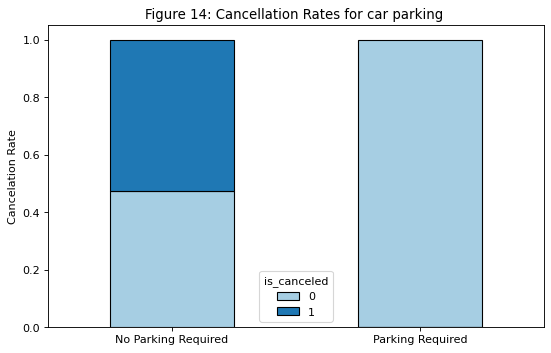

In [32]:
parking = train_set.groupby('binary_car_park')['is_canceled'].value_counts(normalize=True).unstack('is_canceled').plot.bar(
    stacked=True, 
    edgecolor = 'black',color = sns.color_palette("Paired",2))
parking.set_title(
    'Figure 14: Cancellation Rates for car parking '
    )
parking.set(
    xlabel='', 
    ylabel='Cancelation Rate')

parking.set_xticklabels( ('No Parking Required', 'Parking Required') )

plt.xticks(rotation = 360)
plt.show()

Another unexpected and interesting result. When parking is required by the guest, the cancellations never occur, and with no parking required, there is a 50-50 chance they will cancel. Thus, we decided to include this feature in our model.

Now, let us consider lead time distribution.

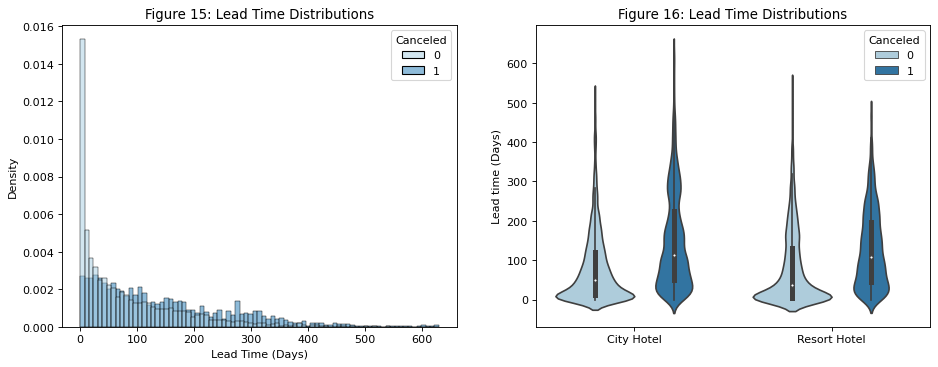

In [33]:
plt.figure(figsize = (14,5))
plt.subplot(1, 2, 2)
Lead_time_ax = sns.violinplot(
    x='hotel', 
    y='lead_time', 
    hue='Canceled',
    palette = sns.color_palette("Paired",2),
    data=train_set.rename(columns={'is_canceled': 'Canceled'}).sort_values('hotel', ascending=True)
    )
Lead_time_ax.set(
    ylabel='Lead time (Days)', 
    xlabel='')
Lead_time_ax.set_title(
    'Figure 16: Lead Time Distributions'
    )

plt.subplot(1, 2, 1) 
Lead_time_ax = sns.histplot(
    hue='Canceled', 
    x='lead_time', 
    stat='density',
    palette = sns.color_palette("Paired",2),
    data=train_set.rename(columns={'is_canceled': 'Canceled'}).sort_values('hotel', ascending=True)
    )
Lead_time_ax.set(
    xlabel='Lead Time (Days)')
Lead_time_ax.set_title(
    'Figure 15: Lead Time Distributions'
    )
plt.show()

From the plot of the lead time distributions, we observe a heavily positive skew for non-cancelled bookings, indicating that a vast majority bookings are made on the same day of arrival. This suggests that most bookings are made within 50 days of arrival, and the frequency of higher lead times decreases as the lead times increase.

We observe a similar trend for the lead times between bookings and cancellations, however without a significantly positive skew. This suggests that as more time passes from the initial booking date, it becomes less likely that a cancellation will be made.

Thus, we keep lead time as a feature due to the variability in the lead times of different cancellation status.

Let us explore how the ADR varies using the market segmentation and distribution channel. 

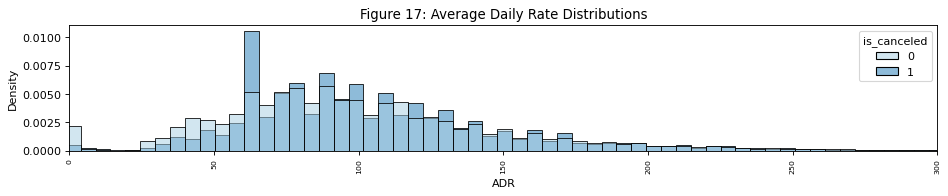

In [34]:
plt.figure(figsize = (14,5))
plt.subplot(2,1,1) 

adr_ax = sns.histplot(
    hue='is_canceled', 
    x='adr', 
    stat='density',
    bins=100,
    data=train_set[train_set['adr'] < 5000],
    palette = sns.color_palette("Paired",2)
    )
adr_ax.set(
    xlabel='ADR')
adr_ax.set_title(
    'Figure 17: Average Daily Rate Distributions'
    )
adr_ax.set(xlim=(0, 300))

plt.xticks(rotation = 90,fontsize=7)
plt.subplots_adjust(hspace=0.4)
plt.show()


We notice high variability in the distribution of the average daily rates therefore we will keep this variable as a feature in the model building process.

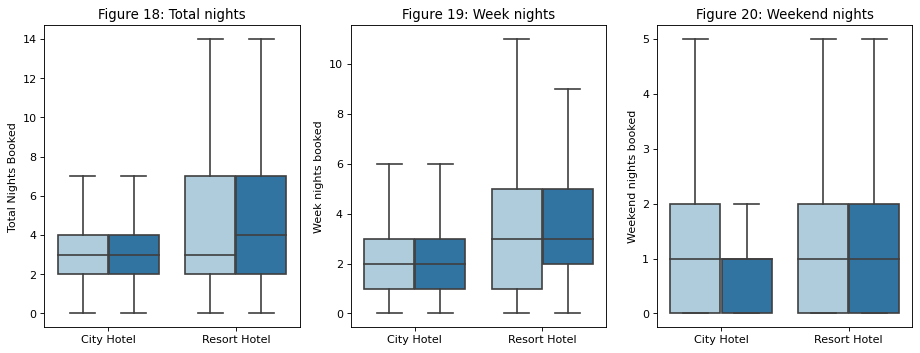

In [35]:
plt.figure(figsize = (14,5))
plt.subplot(1,3,1)
total_stay_ax = sns.boxplot(
    x='hotel', 
    y='stays_nights_total', 
    hue='is_canceled', 
    showfliers = False,
    data=train_set.sort_values('hotel', ascending=True),
    palette = sns.color_palette("Paired",2)
    )
total_stay_ax.set(
    ylabel='Total Nights Booked', 
    xlabel='')
total_stay_ax.set_title(
    'Total Nights'
    )
total_stay_ax.get_legend().remove()
total_stay_ax.set_title(
    'Figure 18: Total nights' )


plt.subplot(1,3,2)
week_stay_ax = sns.boxplot(
    x='hotel', 
    y='stays_in_week_nights', 
    hue='is_canceled', 
    showfliers = False,
    data=train_set.sort_values('hotel', ascending=True),
    palette = sns.color_palette("Paired",2)
    )
week_stay_ax.set(
    ylabel='Week nights booked', 
    xlabel='')
week_stay_ax.set_title(
    'Figure 19: Week nights'
    )
week_stay_ax.get_legend().remove()


plt.subplot(1,3,3)
weekend_stay_ax = sns.boxplot(
    x='hotel', 
    y='stays_in_weekend_nights', 
    hue='is_canceled', 
    showfliers = False,
    data=train_set.sort_values('hotel', ascending=True),
    palette = sns.color_palette("Paired",2)
    )
weekend_stay_ax.set(
    ylabel='Weekend nights booked', 
    xlabel='')
weekend_stay_ax.set_title(
    'Figure 20: Weekend nights'
    )

weekend_stay_ax.get_legend().remove()

plt.show()

Looking at the plot above, we decide not to include those features in our model. The number of nights do not differ significantly.
Now, let us see the number of adults and their respective cancellation rates. 

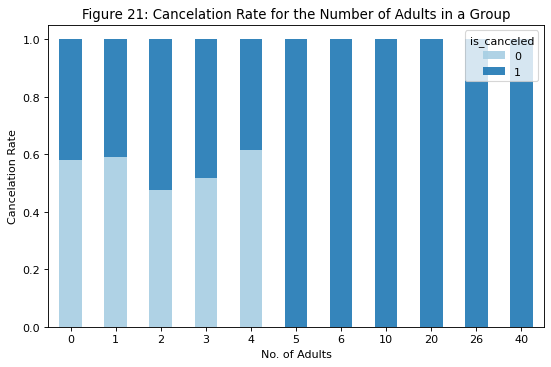

In [36]:
adult = train_set.groupby('adults')['is_canceled'].value_counts(
    normalize = True).unstack('is_canceled').plot.bar(stacked = True, alpha = 0.9, color = sns.color_palette("Paired",2))

adult.set_title('Figure 21: Cancelation Rate for the Number of Adults in a Group' )
adult.set(
    xlabel = 'No. of Adults', 
    ylabel = 'Cancelation Rate'
)
plt.xticks(rotation = 360)
plt.show ()

We see that the cancellation rates occur fairly uniformly for all groups of adults. We notice that the groups with the total number of 5 or more adults are always cancelled. We decided to include this feature in the model on a condition if the single booking is made by 5 or more adults.  

Now, let us consider the cancellations based on special requests.

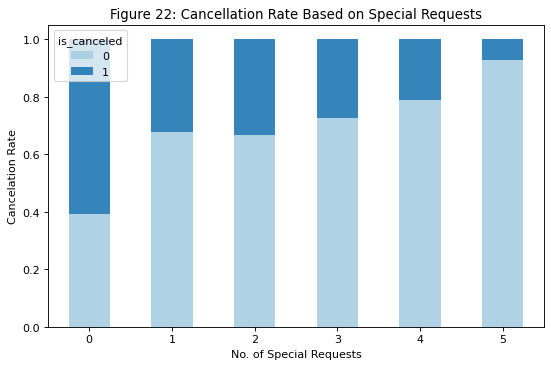

In [37]:
special_request = train_set.groupby('total_of_special_requests')['is_canceled'].value_counts(
    normalize = True).unstack('is_canceled').plot.bar(stacked = True, alpha = 0.9, color = sns.color_palette("Paired",2))
    
special_request.set_title('Figure 22: Cancellation Rate Based on Special Requests' )
special_request.set(
    xlabel = 'No. of Special Requests', 
    ylabel = 'Cancelation Rate'
)
plt.xticks(rotation = 360)
plt.show()

There is a clear upwards trend in the non-cancellation rate as the number of special requests increases, suggesting that guests who make more special requests are more likely to proceed with their bookings. We therefore keep this variable as a feature as it may provide statistical significance when classifying the likelihood of cancellations.

Let us consider the cancellation behaviour based on clients with babies. 

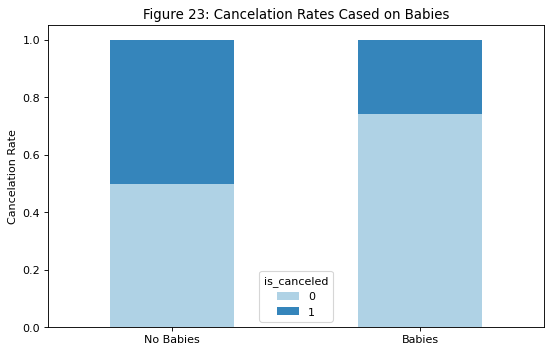

In [38]:
babies = train_set.groupby('binary_babes')['is_canceled'].value_counts(
    normalize = True).unstack('is_canceled').plot.bar(stacked = True, alpha = 0.9, color = sns.color_palette("Paired",2))
    #alpha indicates how opacity of the plot
babies.set_title('Figure 23: Cancelation Rates Cased on Babies' )
babies.set(
    xlabel = '', 
    ylabel = 'Cancelation Rate'
)
babies.set_xticklabels( ('No Babies', 'Babies') )
plt.xticks(rotation = 360)
plt.show()

As we can see, having babies or not having babies, does not differ significantly in the cancellations rates, thus, we will not consider this as a feature in our model.

Now, let us consider the concellation rate based on bookings that include adults and their children. 

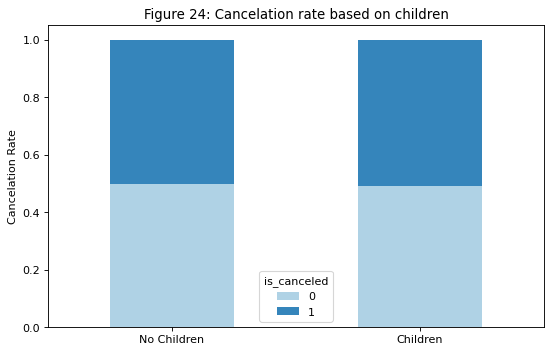

In [39]:
children= train_set.groupby('binary_children')['is_canceled'].value_counts(
    normalize = True).unstack('is_canceled').plot.bar(stacked = True, alpha = 0.9, color = sns.color_palette("Paired",2))
    #alpha indicates how opacity of the plot
children.set_title('Figure 24: Cancelation rate based on children' )
children.set(
    xlabel = '', 
    ylabel = 'Cancelation Rate'
)
children.set_xticklabels( ('No Children', 'Children') )
plt.xticks(rotation = 360)
plt.show()

The proportion of cancellations is 50/50 for both guests with and without children, so clearly children do not impact the cancelation rates. Thus, we will not include this feature in the model.'

Let us move on to the cancellation rate based on the required car park space.

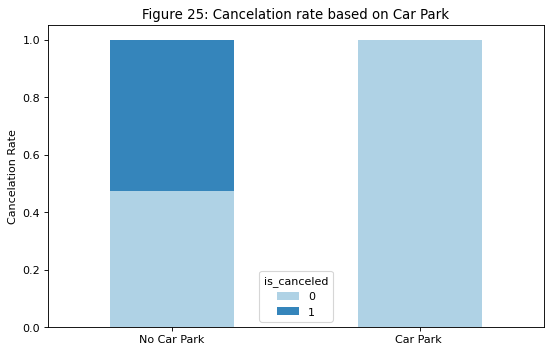

In [40]:
car_park= train_set.groupby('binary_car_park')['is_canceled'].value_counts(
    normalize = True).unstack('is_canceled').plot.bar( stacked = True, alpha = 0.9, color = sns.color_palette("Paired",2))
    #alpha indicates capacity of the plot
car_park.set_title('Figure 25: Cancelation rate based on Car Park' )
car_park.set(
    xlabel = '', 
    ylabel = 'Cancelation Rate'
)
car_park.set_xticklabels( ('No Car Park', 'Car Park ') )
plt.xticks(rotation = 360)
plt.show()

The result above is interesting. Requiring the car park space appears to be an important feature in prediction of a cancellation. Those clients that require a car park space appear never cancel their trips as opposed to those that do not require car parking space. We wish to include this feature in our model. 

Let us move on to the analysis of previous cancellations. 

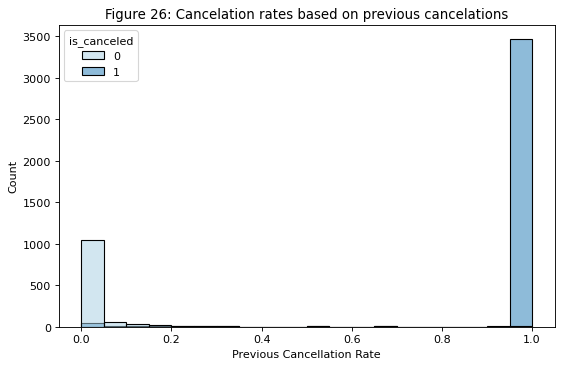

In [41]:
previous_cancelation_ax = sns.histplot(
    hue='is_canceled', 
    x='previous_cancellation_rate', 
    stat='count',
    bins=20,
    data=train_set, 
    palette = sns.color_palette("Paired",2)
    )

previous_cancelation_ax.set(
    xlabel='Previous Cancellation Rate')
previous_cancelation_ax.set_title(
    'Figure 26: Cancelation rates based on previous cancelations'
    )
plt.show()

From the plot above we can deduce that there are around 3500 returning clients that cancel more than 95% of the time, and around 1000 that cancel very rarely. We believe this is an important feature to include, and will be an statistically significant predictor of the behavioural patters of many returning clients. 

Now let us examine the cancellation trends according to the booking changes.

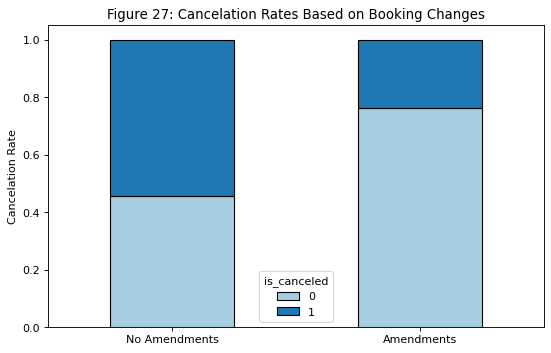

In [42]:
booking = train_set.groupby('binary_booking_changes')['is_canceled'].value_counts(normalize=True).unstack('is_canceled').plot.bar(
    stacked=True, 
    edgecolor = 'black',color = sns.color_palette("Paired",2))
booking.set_title(
    'Figure 27: Cancelation Rates Based on Booking Changes'
    )
booking.set(
    xlabel='', 
    ylabel='Cancelation Rate')

booking.set_xticklabels( ('No Amendments', 'Amendments') )

plt.xticks(rotation = 360)
plt.show()

We can see that if a customer makes an amendment they are less likely to cancel their reservation. If no amendments are made, then at least half of the bookings is cancelled. It appears to be a relevant feature and we decided to include it in the model.

The median number of bookings for an agent is:  14.0


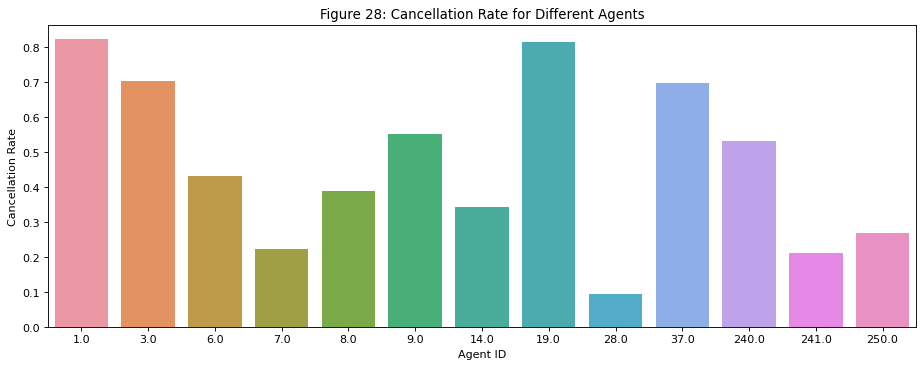

In [43]:
plt.figure(figsize = (14,5))

Agent_df = count_how_many(train_set,'agent')

Agent_df  = Agent_df.pivot_table(
    index = ['agent'], 
    columns = 'is_canceled', 
    values ='count').reset_index().rename(columns = {0:'not_canceled', 1: 'canceled'}).fillna(0)
Agent_df['cancelation_rate'] = Agent_df.canceled/ (Agent_df.canceled + Agent_df.not_canceled)
Agent_df['number_of_bookings'] = Agent_df.canceled+Agent_df.not_canceled

print('The median number of bookings for an agent is: ',Agent_df['number_of_bookings'].median())

agents_most_bookings = Agent_df[Agent_df['number_of_bookings']>500]

Agent_ax = sns.barplot(x = 'agent', y = 'cancelation_rate',
            data = agents_most_bookings)

plt.xlabel('Agent ID')
plt.ylabel('Cancellation Rate')
plt.title('Figure 28: Cancellation Rate for Different Agents')
plt.show()


We believe that agent is an essential feature. We see that 50% of the agents have made 13 or more bookings, thus we explored the dataset by filtering the column. In the figure above we see the 13 agents and the cancellation rates of their clients. There is a very high variability here as we see that some agents have a higher probability of being cancelled than others. In particular, we see that the agent with `ID number 1` has a cancellation rate over 80%, suggesting that those who book with this agent do not follow through with their bookings. On the other hand,the agent with `ID number  28` has a cancellation rate of approiximately 10%, suggesting that those who book through this agent are very serious about their bookings. We decide to include this feature in our model as it may provide statistical power in classifying the cancellation status. 

### Summary of all features considered in the model
The following features will be considered in the model:

1. `country_name`
2. `market_segment`
3. `customer_type`
4. `binary_car_park`
5. `lead_time`
6. `adr`
7. `hotel`
8. `arrival_date_week_number`
9. `deposit_type`
10. `agent`
11. `adults`
12. `total_of_special_requests`
13. `binary_babes`
14. `previous_cancellations`
15. `binary_booking_changes`

## 3. Understanding reasons behind cancellations
In this section, we will summarise our findings of various reasons of cancellations. 

1. Parents are more likely to cancel having infants.
2. Clients requiring parking space are less likely to cancel than those who do not. It gives a reason to suggest that they planned their holiday, and are more committed to their reservation.
3. Clients from Portugal, Brazil and Italy cancel most often.
4. The more number of special requests, the less likely person will cancel.
5. Bookings of 5+ adults always get cancelled. 
6. No refundable deposits reservations always get canceled. 
7. Certain agents have especially high cancellation rate of bookings from clients. 
8. The more amendments are made to the booking, the less likely it is for a client to cancel.
9. Based on the records of previous cancellations, certain clients always cancel their bookings. 
10. Cancellations for City Hotel seem to be uniform throughout the year, but for Resort Hotel, we see that less cancellations occur in November, December and January. 


## 4. Model Fitting and Tuning

After exploring the data and understanding the cancellations reasons, the most relevant features were chosen.

The focus of this task is to build a model with high accuracy with the least false positives. False positive is also known as "Type I" error and it occurs when the model incorrectly predicts a positive outcome (cancelled bookings). 

Having a machine learning model to predict the booking cancellations would be useful for the hotel operator, however a Type I error may impact the hotels' resource planning and may cause the operator to lose out on potential profits due to overbooking (i.e. the hotel measures their availability based on currently available rooms plus rooms from reservations that are predicted to be cancelled).

## Classification models 
We have explored four models: Logistic Regression, Support Vector Classifier (SVC), Classification Tree and Random Forest. The following table summarizes our findings. 

| Model | Accuracy | True Positive | False Positive
| :- | :-: | :-: | :-: |
| Logistic Regression | 0.775 | 0.740 | 0.190
| SVC | 0.774 | 0.740 | 0.190
| Classification Tree | 0.815 | 0.780 | 0.150
 


### Random Forest
Random Forest proved to be the best model and we include the details of the model fitting and tuning in the following section.

In the exploration phase we learned that a group consisting of 5+ adults always cancel. In the cell below we create a feature that considers a group of 5+ adults. 

In [44]:
# New feature for considering large adult group (>= 5)
d_balanced["large_group"] =np.where(d_balanced["adults"]>=5, 1, 0)

Below, we show out initial selection of the features. We performed one hot encoding for the `customer_type`, `deposit_type`,`market_segment`, `country_name` and split the data. 

In [45]:
# Features

features = d_balanced[["country_name", "market_segment", "customer_type",
"binary_car_park", "arrival_date_week_number", "deposit_type", "agent", "large_group",
"total_of_special_requests", "previous_cancellations", 
"binary_booking_changes"]]

X = pd.get_dummies( 
    features, 
    columns = ["customer_type", "deposit_type","market_segment", "country_name"], 
    drop_first = True
    )

y =d_balanced['is_canceled'] # Outcome variable

# Data splitting
X_train, X_h, y_train, y_h = train_test_split(X, y, test_size=0.4, random_state = 123, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_h, y_h, test_size=0.5, random_state = 123, stratify = y_h)


Initially, the models were built using all the features (including all dummies). These variables may not offer any value. This is observed especially in the `country_names` as there are 144 unique countries in the dataset, and having a dummy variable for each country name resulted in having around 172 features in total. We realised that the portion of them might have not been relevant for describing the cancellation rate in the dataset. For example, Portugal proved to be very important in comparison to other countries, since its' cancelation rate is higher than all of the other countries (area under the curve was around 0.875).

We execute a feature importance using Permutation Feature Importance, which is a model inspection technique that can be used for any fitted estimator when the data is tabular. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. We referenced the methodology in the link number 3 in the 'References and Hints' section. 

In the cell below, we show the result of the feature importance output from the random forest model. We identified variables that were not relevant for the tree. Also, to avoid overfitting, we decided to reduce the number of features in the model. This is because some may only carry noise and will not be useful for the model.

In [46]:
# New features

relevant_features = ["total_of_special_requests", "previous_cancellations", 
"market_segment_Online TA", "market_segment_Offline TA/TO", "market_segment_Groups",
"market_segment_Direct", "market_segment_Corporate", "deposit_type_Non Refund",
"customer_type_Transient-Party", "customer_type_Transient", "country_name_Portugal",  
"binary_car_park", "binary_booking_changes", "arrival_date_week_number","agent"]

Below we divide the data of the `relevant_features` into train, test and validation sets. 

In [47]:
# Subsets

X_train = X_train[relevant_features]
X_val = X_val[relevant_features]
X_test = X_test[relevant_features]

In order to find the hyperparameters used for the random forest model, grid search cross-validation was used. This approach will find the best hyperparameters using k number of folds to train and validate in each fold. The number of folds is defined to be 5 as a standard practice in machine learning. 

In [48]:
# Grid search for Random forest using max_depth, n_estimators and max_features
rf_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(), 
        RandomForestClassifier(max_samples=0.8)
        ),
    param_grid={
        "randomforestclassifier__max_depth": [5, 10, 20],
        "randomforestclassifier__n_estimators": [10, 20, 50, 100],
        "randomforestclassifier__max_features": [2, 5, 10, 15, 18]},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="accuracy"
    ).fit(X_train, y_train)

In [54]:
rf_gs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 2,
 'randomforestclassifier__n_estimators': 100}

Then, we make a pipeline, and find the accuracy score of the model and the confusion matrix using the best parameters. 

Fine tuning is done against the validation set for ensuring a higher accuracy and minimizing the false positives.

In [49]:
rf_mdl = make_pipeline(
        StandardScaler(), 
        RandomForestClassifier(
            n_estimators = 100,
            max_depth = 20, max_samples  = 0.8, 
            max_features = 8 )
        ).fit(X_train, y_train)

The models explored in this project were compared using the validation set. After deciding the final model to implement, the model is assessed against the test set.

Accuracy score:  0.8280949689089881


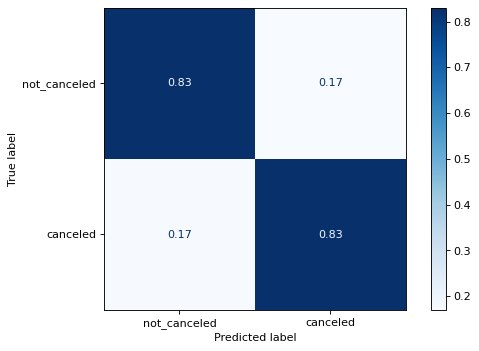

In [50]:
model_assessment(rf_mdl, X_val, y_val)
plt.show()

Accuracy score:  0.8228377614471453


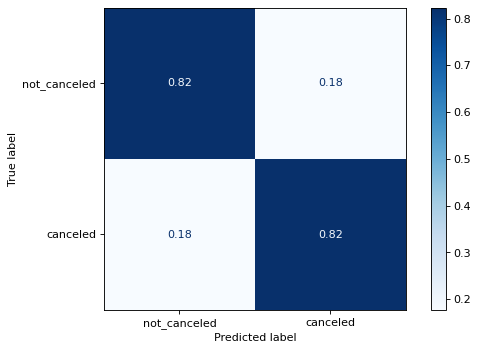

In [51]:
model_assessment(rf_mdl, X_test, y_test)
plt.show()

The model accuracy, true positives and false positives using the test set is relatively similar to what was obtained in the validation set. This is a result that gives confidence that the model will perform in a similar fashion with unseen data (test data, or future data that will be used by the hotel operator).

We now visualize the model using a tree plot. Since this model has a high number of estimators (trees), we will look at one tree for analysis purposes.

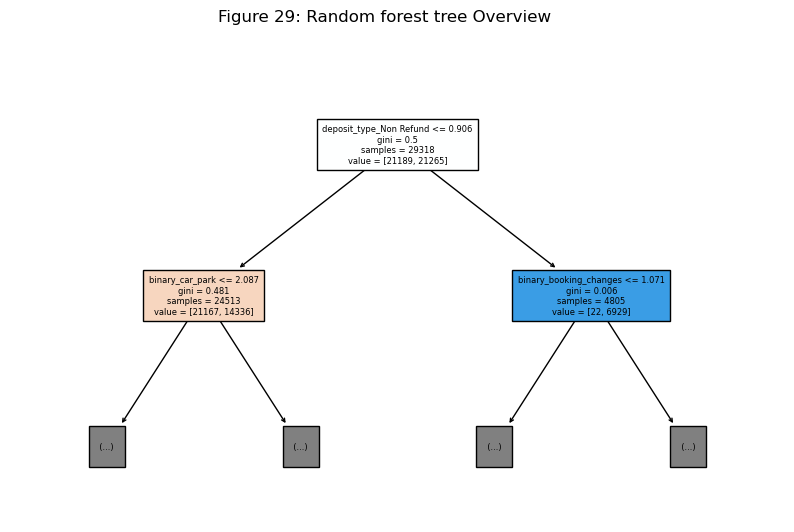

In [52]:
plt.figure(figsize=(10,6), dpi = 100)
plt.suptitle('Figure 29: Random forest tree Overview')
tree.plot_tree(rf_mdl[1].estimators_[0],feature_names = relevant_features, 
filled = True,max_depth = 1, fontsize = 6)

plt.show()

As it can be seen in the figure 29, the random forest tree splits the data in two branches by considering the contribution of the most relevant feature; which is the Non-refund deposit type. Every node splits into different classes and a good child node is considered to be the one with higher Gini value. 

In the first split, the data is splitted in two segments: one where the non-refund deposit type contribution has a value lower or equal to 0.901, and a segment with contribution greater than 0.901. The box on the left (contribution <= 0.901) has a Gini value of **0.481**., while the box on the right (dark blue color box) has a Gini value of **0.009**. This lower Gini value means that the model did not improve between the parent and the child node. The split will continue until the gini gain reaches a value of zero (no improvement between the parent and the child node). 

Without loss of generality, this is the same logic that is followed by each node in the tree, and it is the same for each tree in the forest.

Let us move to the conclusion section to discuss the results above. 

## 5. Discussion & Conclusions


The built model for this hotel operator considers the following features:

1. total_of_special_requests
2. previous_cancellations
3. market_segment_Online TA
4. market_segment_Offline 
5. market_segment_TA/TO 
6. market_segment_Groups
7. market_segment_Direct 
8. market_segment_Corporate
9. deposit_type_Non Refund
10. customer_type_Transient-Party
11. customer_type_Transient
12. country_name_Portugal 
13. binary_car_park
14. binary_booking_changes 
15. arrival_date_week_number
16. agent

This model was built after exploring and analyzing the historical data provided. The chosen model is a Random Forest. The effort made for building the model is for predicting whether a cancellation occurs or not.

Hotels and any hospitality businesses use bookings as their way to offer a service, and while it is important to understand the cancellations, a business needs to have confidence on the cancellations that will ocurr in a certain time period. 

Customer satisfaction is an important measure of success for a hotel business, as prospective customers will likely read reviews from booking websites to decide which hotel to book for their holiday. This being said, if a hotel uses a model that wrongly predicts cancellations when they do not happen, this can impact on the client-hotel trust when the hotel overbooks rooms and customers may not be able to stay in their preferred choice. 

This is the driving force for building a model that not only accurately predicts an actual cancellation; but it does not falsely predict a cancellation. False cancellation predictions are called "False positives" (Type I error) and the machine learning model chosen granted the lowest Type I error. This model offers a prediction accuracy of 0.82 and a true positive rate of 0.82. To a business, having a high true positive rate, it gives certainty about the cancellation rate that will occur.

While a perfect model may only exist for toy examples in books, this machine learning model offers a high accuracy and an enhancement to hotel business existing operation. The model can be useful for planning ahead for peak seasons ensuring that customers will enjoy their holiday at their desired hotel. 

## References and Hints: 
1) Hotel booking demand datasets:  https://www.sciencedirect.com/science/article/pii/S2352340918315191?via%3Dihub <br>
2) Sorting a pandas data frame by month:  https://stackoverflow.com/questions/48042915/sort-a-pandass-dataframe-series-by-month-name <br>
3) Perumtation Feature Importance: https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature <br>
4) Sorting dataframe series by month name: https://stackoverflow.com/questions/48042915/sort-a-pandass-dataframe-series-by-month-name <br>


## Convert Document

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93dd4c12-9a33-4e97-815b-3e4ec449151b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>